In [1]:
from web3 import Web3, HTTPProvider
import json
from decimal import Decimal
import time 
import decimal
math = decimal.Context()
import numpy 
import random
%matplotlib inline
import matplotlib
import pandas
import subprocess
import web3

In [ ]:
import os
os.chdir('./dapp/')

In [2]:
url = 'http://127.0.0.1:8545' 
w3 = Web3(Web3.HTTPProvider(url))
accounts = w3.eth.accounts

In [4]:
web3.types.Wei(10)

10

In [2]:
# Installing app
# npm init
# npm install --save-dev @nomiclabs/buidler
# npx buidler
# Follow instructions to create new project

# When project is ready
# Run: 
# npx buidler node

# run the script (Learn more: https://buidler.dev/guides/scripts.html )
# npx buidler --network localhost run scripts/pyTokenTest.js


# use web3 to advance blocks/block time with ganache:
# https://medium.com/fluidity/standing-the-time-of-test-b906fcc374a9

In [188]:
# Get contract addresses from ./artifacts/addresses.json
with open('./artifacts/addresses.json') as file:
    addresses = json.load(file)

In [189]:
addresses

{'collateral': '0x03049DF4d8730C375CAe2c13a542cCE873369e20',
 'underlying': '0x99b0df288A2Ddf84850157b04ef653833e668abE',
 'oracle': '0xe3962a83c698CC25DFF81F98B08a9c2e749B367C',
 'pytoken': '0x12Cd007817Ff0343cB5dd4b26bcF678D50ab6aE7'}

In [194]:
def getContract(fileLocation, address):
    with open(fileLocation) as file:
        abi_json = json.load(file)
    contract_abi = abi_json['abi']
    return w3.eth.contract(address = Web3.toChecksumAddress(address), 
                                              abi = contract_abi)

In [8]:
collateral = getContract('./artifacts/Collateral.json', addresses['collateral'])

In [12]:
toMint = (100*10**18)
collateral.functions.mint(toMint).transact({'from': accounts[0]})

HexBytes('0x09d01c0d0d7d98564c3784a1fc6cf2014d288495157797d520d17904e4e83b69')

In [13]:
collateral.functions.balanceOf(accounts[0]).call()

100000000000000000000

In [10]:
underlying = getContract('./artifacts/Underlying.json', addresses['underlying'])

In [14]:
toMint = (100*10**18)
underlying.functions.mint(toMint).transact({'from': accounts[0]})

HexBytes('0xcfe5d42c2e1fb35e77c5864ef7f4772886bd09f3ddaa13f871853587f0ca5d26')

In [15]:
oracle = getContract('./artifacts/Oracle.json', addresses['oracle'])

In [16]:
price = (2*10**18)
oracle.functions.updatePrice(price).transact({'from': accounts[0]})

HexBytes('0x48fecf760dcd9f32b76af9d28b61244404bdc125e6b5f349b6d5a8663da27116')

In [18]:
pytoken = getContract('./artifacts/pyToken.json', addresses['pytoken'])

In [19]:
pytoken.functions.reservesTarget().call()

300000000000000000

## Block and time updates

In [20]:
w3.eth.blockNumber

23

In [21]:
def getBlockTimestamp():
    return w3.eth.getBlock(w3.eth.blockNumber).timestamp

def advanceBlock():
    w3.provider.make_request('evm_mine', [])
    
def advanceTime(seconds):
    w3.provider.make_request('evm_increaseTime', [seconds])
    
def takeSnapshot():
    return w3.provider.make_request('evm_snapshot', [])['result']

def revertToSnapShot(snapshot):
    return w3.provider.make_request('evm_revert', [snapshot])['result']

def getBlockNumber():
    return w3.eth.blockNumber

## Interacting with the contract

In [22]:
class Token:       
    def __init__(self, _name, _contract):
        self.balances = {}
        self.totalSupply = 0
        self._name = _name
        self.contract = _contract
    
    def mint(self, address, amount):
        self.contract.functions.mint(amount).transact({'from': address})
    
    def balanceOf(self, address):
        return self.contract.functions.balanceOf(address).call()
    
    def name(self):
        return self._name
    
    def allowance(self, owner, spender):
        return self.contract.functions.allowance( owner, spender).call()
    
    def approve(self, address, spender, amount):
        return self.contract.functions.approve(spender, amount).transact({'from': address})
    
    def transferFrom(self, sender, recipient, amount):
        assert(amount >= 0)
        return self.contract.functions.transfer(recipient, amount).transact({'from': sender})
    
    

In [23]:
ctoken = Token("collateral", collateral)

In [24]:
ctoken.mint(accounts[3], 100*10**18)

In [25]:
ctoken.balanceOf(accounts[3])

100000000000000000000

In [26]:
ctoken.transferFrom(accounts[3],accounts[4], int(1.7234 * 10**18))

HexBytes('0x91578d0cad56e3d1cdd0d8f44f10b0ef109762342b87b526536f8d2e6ac7696b')

In [27]:
ctoken.balanceOf(accounts[4])

1723400000000000000

In [28]:
utoken = Token("underlying", underlying)

In [29]:
utoken.mint(accounts[4], 100*10**18)

In [30]:
utoken.balanceOf(accounts[4])

100000000000000000000

In [32]:
utoken.allowance(accounts[4], addresses['pytoken'])

0

## Oracle

In [670]:
class Oracle:       
    def __init__(self, _oracle):
        self.oracle = _oracle
        self.saved = -1
      
    def updatePrice(self, newPrice):
        self.oracle.functions.updatePrice(newPrice).call()
        
    def endTWAP(self ):
        if self.saved == -1:
            self.saved = self.oracle.functions.endTWAP().call()
        return self.saved



In [34]:
pyoracle = Oracle(oracle)

In [35]:
pyoracle.endTWAP()

2000000000000000000

# pyToken contract

In [838]:
class pyToken():
    def __init__(self,  _pyToken):  
        self.pytoken = _pyToken
        self._counts = {}
        self.blockNumber = 0
        self.lastInterestBlockNumber = -1
        self.lastRABlockNumber = -1
        self.underlyingValid = False
    
    def updateBlock(self, blockNumber):
        self.blockNumber = blockNumber
    
    #View functions
    def toDecimal(self, value, length=Decimal(10**18)):
        return Decimal(value) / length
    
    def counts(self, key):
        self._counts[key] = self._counts.get(key, 0) + 1
    
    
    def yearlyDebtRate(self):
        self.counts('debtRate')
        rate = self.toDecimal(self.pytoken.functions.debtRate().call(), Decimal(10**27))
        return math.power(rate, Decimal(31622400)) - 1
    
    def yearlyRate(self):
        if self.lastInterestBlockNumber == self.blockNumber:
            return self.lastInterestSaved
        else:
            self.counts('lastBlockInterest')
            self.lastInterestBlockNumber = self.blockNumber
            rate = self.toDecimal(self.pytoken.functions.lastBlockInterest().call(), Decimal(10**27))
            periods = Decimal(self.pytoken.functions.lastBlockInterestPeriods().call())
            rate = math.power(rate, Decimal(1)/periods)
            self.lastInterestSaved = math.power(rate, Decimal(31622400)) - 1
            return self.lastInterestSaved
    
    def balanceOf(self, address):
        self.counts('balanceOf')
        return self.pytoken.functions.balanceOf(address).call()
    
    def collateralizationRatio(self):
        self.counts('collateralizationRatio')
        return self.pytoken.functions.collateralizationRatio().call()
    
    def getTotalDebt(self):
        self.counts('getTotalDebt')
        return self.pytoken.functions.getTotalDebt().call()
    
    def getReserveRatio(self):
        self.counts('getReserveRatio')
        return self.pytoken.functions.getReserveRatio().call()
    
    def getCollateral(self, token, address):
        pass
    
    def getDebt(self, token, address):
        pass

    def getCollateralBalance(self, address):
        self.counts('getCollateralBalance')
        return self.pytoken.functions.getCollateralBalance(address).call()
    
    def debtInUnderlying(self, address):
        self.counts('debtInUnderlying')
        return self.pytoken.functions.debtInUnderlying(address).call()
    
    def balanceOfUnderlying(self, address):
        return self.balanceOf(address) * self.rateAccumulator()
    
    def rateAccumulator(self):
        if self.lastRABlockNumber == self.blockNumber:
            return self.lastRASaved
        else:
            self.counts('rateAccumulator')
            self.lastRABlockNumber = self.blockNumber
            self.lastRASaved = self.toDecimal(self.pytoken.functions.rateAccumulator().call(), Decimal(10**27))
            return self.lastRASaved
     
    def totalSupplyUnderlying(self):
        pass
    
    def totalSupply(self):
        self.counts('totalSupply')
        return self.pytoken.functions.totalSupply().call()
    
    def underlyingHeld(self):
        if self.underlyingValid:
            return self.lastUnderlying
        else:
            self.counts('underlyingHeld')
            self.underlyingValid = True
            self.lastUnderlying = self.pytoken.functions.underlyingHeld().call()
            return self.lastUnderlying
    
    def totalFeeIncome(self):
        self.counts('totalFeeIncome')
        return self.pytoken.functions.totalFeeIncome().call()
    
    
    #ERC-20
    def transferUnderlying(self, sender, recipient, amount):
        pass
    
    # User Functions
    
    def mint(self, address, amount):
        self.underlyingValid = False
        self.counts('mint')
        return pytoken.functions.mint(amount).transact({'from': address})
    
    def redeem(self, address, amount):
        self.underlyingValid = False
        self.counts('redeem')
        return pytoken.functions.redeem(amount).transact({'from': address})
        
    def mintInUnderlying(self, address, amount):
        raise Exception("Function implementation not valid")
        self.underlyingValid = False
        self.counts('mint')
        pytoken.functions.mint(amount).transact({'from': address})
        return self.mint(address, amount/self.rateAccumulator)
        
    def burnInUnderlying(self, address, amount):
        return self.burn(address, amount/self.rateAccumulator)
    
    def addCollateral(self, address, amount):
        self.counts('addCollateral')
        return pytoken.functions.addCollateral(address, amount).transact({'from': address})
      
    def withdrawCollateral(self, token, address, amount):
        self.counts('withdrawCollateral')
        return pytoken.functions.withdrawCollateral(address, amount).transact({'from': address})
    
    # accrue for both debt and interest
    def accrueInterest(self):
        self.counts('accrueInterest')
        return pytoken.functions.accrueInterest().transact()
    
    def updateRates(self):
        self.counts('updateRates')
        return pytoken.functions.updateRates().transact()
    
    # borrow against a particular tokens worth of collateral
    def completeBorrow(self, token, address, amount, collateralToLock):
        self.counts('completeBorrow')
        return pytoken.functions.completeBorrow(address, amount, collateralToLock).transact({'from': address})
        
    def maximumBorrow(self, token, address):
        pass

       
    def liquidate(self, token, addressToLiquidate, LiquidatorAddress, amount):
        pass
        
    # Position in a particular collateral token
    def position(self, token, address):
        pass
    
    def repay(self, token, address, amount):
        self.counts('repay')
        return pytoken.functions.repay(address, amount).transact({'from': address})


In [823]:
pyA = pyToken(pytoken)




In [824]:
pyA.pytoken.address

'0x218C88D54d29AeEd94A9D48CcB91988A354FDDa7'

In [825]:
pyA.yearlyDebtRate()

Decimal('0.021967514450740227154087140')

In [826]:
pyA.balanceOfUnderlying(accounts[1])

Decimal('6100245906118126.440486908704')

In [827]:
pyA.yearlyRate()

Decimal('0.015046536604454303590900401')

In [828]:
pyA.underlyingHeld()

184734455126311348204

In [359]:
utoken.approve(accounts[4],addresses['pytoken'], 100*10**18)

HexBytes('0x282a47121c0213867fae40b7b23756d73c4a7da3b641532adfd0fae197a35396')

In [360]:
accounts[4]

'0x2fFd013AaA7B5a7DA93336C2251075202b33FB2B'

In [361]:
addresses['pytoken']

'0xB45E8Ea8FFA780ad7576cf5A6bB777ce7395AE93'

In [362]:
utoken.allowance(accounts[4], addresses['pytoken'])

100000000000000000000

In [363]:
pyA.pytoken.functions.underlying().call()

'0x0FDA0F29CeeA87c63d7F8F60Be83b20ffcBe656B'

In [364]:
utoken.approve(accounts[4], addresses['pytoken'], 1*10**18)
pyA.mint(accounts[4], 1*10**17)

ValueError: {'code': -32603, 'message': 'VM Exception while processing transaction: revert ERC20: transfer amount exceeds balance'}

In [365]:
pyA.balanceOf(accounts[4])

0

## Simulation

In [366]:
class blockchain:
    
    def __init__(self, _timestamp, _block):
        self.timestamp = _timestamp
        self.block = _block
    
    def incrementBlock(self):
        advanceBlock()
    
    def updateTimestamp(self, _timestamp):
        seconds = _timestamp - getBlockTimestamp()
        advanceTime(seconds)
        advanceBlock()
    
    def blockNumber(self):
        return getBlockNumber()
    
    def now(self):
        return getBlockTimestamp()

In [367]:
class Interface:
    
    def __init__(self, _chain : blockchain, _uTokenA : Token, _uTokenB : Token, _oracle, _pyA):
        self.A = _uTokenA
        self.B = _uTokenB
        self.chain = _chain
        self.oracle = _oracle
        self.pyA = _pyA
        
    def updateInterestRates(self):
        self.pyA.updateRates()
        self.pyA.accrueInterest()
    
    def eachBlock(self):
        self.chain.incrementBlock()
        self.updateInterestRates()
        


In [368]:
class Agent:
    def __init__(self, _interface):
        self.interface = _interface
        self.address = numpy.random.randint(1,1000)
        
    def setup(self):
        pass
    
    def performActions(self):
        pass
    
    def shutdown(self):
        pass

In [853]:
def fNumber(number):
    return int(number * Decimal(10**18))
    
def unNumber(number):
    return Decimal(number) / Decimal(10**18)
    
class YieldAgent(Agent):
    def __init__(self, _interface):
        super().__init__(_interface)
        self.address = random.choice(accounts)
        self.block = 0
        
    def setup(self):   
        self.initialA = min(Decimal(round(numpy.random.lognormal(3, 1))), Decimal(1000))
        self.interface.A.mint(self.address, fNumber(self.initialA))
        self.lowerRate = Decimal(numpy.random.uniform(0,3) / 100)
        self.upperRate = self.lowerRate + Decimal(numpy.random.uniform(0,2) / 100)
        self.AUsed = 0
        print("Yield Agent lower Rate: {} Upper Rate: {}".format(self.lowerRate , self.upperRate))
    
    def performActions(self):
        rate = self.interface.pyA.yearlyRate()
        #print("rate: {}, upperRate {}".format(rate, self.upperRate))
        if  rate > self.upperRate:
            self.HODL()
        elif rate < self.lowerRate:
            self.unHODL()
            
    def HODL(self):
        self.block = self.interface.chain.blockNumber()
        if self.AUsed < self.initialA:
            aBalance = min(unNumber(self.interface.A.balanceOf(self.address)), self.initialA-self.AUsed)
            self.interface.A.approve(self.address, self.interface.pyA.pytoken.address, fNumber(aBalance))
            self.interface.pyA.mint(self.address, fNumber(aBalance))
            print("HODLing {} tokens at rate {}".format(aBalance, round(self.upperRate, 4)))
            self.AUsed += aBalance
            
    def unHODL(self):
        if self.block - self.interface.chain.blockNumber() < 10:
            return
        amount = min(unNumber(self.interface.pyA.balanceOfUnderlying(self.address)), 
                     unNumber(self.interface.pyA.underlyingHeld()),
                     self.initialA
                    )
        amount = amount*Decimal('0.1')
        if amount > 0 and amount < self.AUsed:
            # let's only remove 10% at a time
            self.interface.pyA.redeem(self.address, fNumber(amount))
            print("unHODLing {} tokens".format(amount, round(self.lowerRate, 4)))
            self.AUsed -= amount
            
            
            

In [875]:
# Borrow agents lever up on ETH collateral by selling pyTokens
class BorrowAgent(Agent):
    def __init__(self, _interface):
        super().__init__(_interface)
        self.address = random.choice(accounts)
        
    def setup(self):
        self.initialB = min(Decimal(round(numpy.random.lognormal(7, 1))), Decimal(100))
        self.interface.B.mint(self.address, fNumber(self.initialB ))
        BReserve = self.initialB * Decimal('0.1')
        self.each = (self.initialB - BReserve)/2
        self.interface.B.approve(self.address, self.interface.pyA.pytoken.address, fNumber(self.each))
        self.interface.pyA.addCollateral(self.address, fNumber(self.each) )
        self.collateralizationRatio = unNumber(self.interface.pyA.collateralizationRatio())
        
        # Below needs updated
        # price = self.interface.ethAOracle.getPriceInToken(self.interface.A)
        self.desiredBorrow = Decimal('0.5')*unNumber(self.interface.oracle.endTWAP())*self.each
        
        self.interface.A.mint(self.address, fNumber(self.desiredBorrow*1000))
        self.lowerRate = Decimal(numpy.random.uniform(0,10) / 100)
        self.upperRate = self.lowerRate + Decimal(numpy.random.uniform(0,5) / 100)
        print("Borrow Agent lower Rate: {} Upper Rate: {}".format(self.lowerRate , self.upperRate))
    
    def maximumBorrow(self): 
        return unNumber(self.interface.pyA.getCollateralBalance(self.address))* unNumber(self.interface.oracle.endTWAP())/  \
                    (self.collateralizationRatio)
    
    def performActions(self):
        rate = self.interface.pyA.yearlyRate()
        if rate > self.upperRate:
            self.unBorrow()
        elif rate < self.lowerRate:
            self.borrow()
        uAmount = min(unNumber(self.interface.pyA.balanceOfUnderlying(self.address)), unNumber(self.interface.pyA.underlyingHeld()))
        if uAmount > Decimal('0.1'):
            self.interface.pyA.redeem(self.address, fNumber(Decimal(uAmount)*Decimal(.99)))
            print("Withdrew {} tokens at {}".format(round(uAmount*Decimal(.99), 4), round(self.lowerRate, 4) ))
            
            
    def borrow(self):
        price = unNumber(self.interface.oracle.endTWAP())
        #if we've already mostly borrowed what we desire, let's stop
        debt = unNumber(self.interface.pyA.debtInUnderlying( self.address))
        if debt > (Decimal('.99') * self.desiredBorrow):
            return
        #initiate borrow
        borrowRatio = Decimal('0.5')
        amount = self.maximumBorrow() - debt
        borrow = (Decimal(amount) * borrowRatio) / Decimal(self.collateralizationRatio )
        if borrow > Decimal('0.1'):
            collateralToLock = fNumber((borrow * self.collateralizationRatio * Decimal(1.01)) / price)
            try:
                self.interface.pyA.completeBorrow("ETH", self.address, fNumber(borrow), collateralToLock)
            except:
                print("failed to borrow. To borrow: {} collateral: {}".format(borrow, unNumber(collateralToLock)))
            # self.interface.pyA.borrow("ETH", self.address, fNumber(borrow))
            print("Borrowed {} tokens at {}".format(round(borrow, 4), round(self.lowerRate, 4) ))

    
    def unBorrow(self):
        amount = Decimal('0.95') * unNumber(self.interface.pyA.debtInUnderlying(self.address))
        #funds = self.interface.A.balanceOf(self.address)
        #toUnBorrow = min(debt, funds)
        if amount > Decimal('0.1'):
            try:
                self.interface.A.approve(self.address, self.interface.pyA.pytoken.address, fNumber(amount*Decimal(1.01)))
                self.interface.A.mint(self.address, fNumber(amount*Decimal(1.01)))
                self.interface.A.approve(self.address, self.interface.pyA.pytoken.address, fNumber(amount*Decimal(1.005)))
                self.interface.pyA.mint(self.address, fNumber(amount*Decimal(1.005)))
                self.interface.pyA.repay("ETH", self.address, fNumber(amount))
                print("unBorrowed {} tokens at {}".format(round(amount, 4), round(self.upperRate, 4) ))
            except Exception as e: 
                print("failed to unborrow. amount:{} underlying balance: {} pyTokens: {} ".format(amount, self.interface.A.balanceOf(self.address), self.interface.pyA.balanceOfUnderlying(self.address)))
                raise e
    


## Simulation Loop

In [876]:
# re-deploy contract
output = subprocess.check_output('npx buidler --network localhost run scripts/pyTokenTest.js', shell=True)
print(output)

b'All contracts have already been compiled, skipping compilation.\nCollateral address: 0xed4aD068e07A8F97Ee8863bEB98A34e93a62CEC7\nUnderlying address: 0x3F9A2a083787f791840b41ACCc2c81718DcAAD5c\nOracle address: 0x97035A8889E88F0391920d0ca79BeF8Ea0B2f40D\npyToken address: 0x059c59322258E708b903dAa3d1E2D8f55EF0fF75\n{\n    "collateral": "0xed4aD068e07A8F97Ee8863bEB98A34e93a62CEC7",\n    "underlying": "0x3F9A2a083787f791840b41ACCc2c81718DcAAD5c",\n    "oracle": "0x97035A8889E88F0391920d0ca79BeF8Ea0B2f40D",\n    "pytoken": "0x059c59322258E708b903dAa3d1E2D8f55EF0fF75"\n}\n'


In [877]:
with open('./artifacts/addresses.json') as file:
    addresses = json.load(file)

collateral = getContract('./artifacts/Collateral.json', addresses['collateral'])
underlying = getContract('./artifacts/Underlying.json', addresses['underlying'])
oracle = getContract('./artifacts/Oracle.json', addresses['oracle'])
pytoken = getContract('./artifacts/pyToken.json', addresses['pytoken'])

In [878]:
ctoken = Token("collateral", collateral)
utoken = Token("underlying", underlying)
pyoracle = Oracle(oracle)
pyA = pyToken(pytoken)

In [879]:
price = (2*10**18)
oracle.functions.updatePrice(price).transact({'from': accounts[0]})
pyoracle.endTWAP()

2000000000000000000

In [880]:
import numpy

chain = blockchain(1,1)
#tokenA = Token("TokenA")
#tokenB = Token("TokenB")
#oracle = Oracle(tokenA, tokenB)
#oracle.setPrice(Decimal('1'))
interface = Interface(chain, utoken, ctoken, pyoracle, pyA)

#interface.pyA.interestUpdateAmount = Decimal('0.0001')
#interface.pyA.reservesTarget = Decimal('0.25')
#interface.pyA.minimumSpread = Decimal('0.0')
#interface.pyA.adjustmentFreeWindow = Decimal('0.01')

# tracking variables
pyAinterest = []
pyBinterest = []
qxA = []
qxB = []
pyratesA = []
debtratesA = []
tSupply = []
ulying = []
debtOutstanding = []
debtSupplyRatio = []
feeIncome = []
rateA = []


# Initial positions
#interface.A.mint("HODL", Decimal(100000))
#interface.B.mint("HODL", Decimal(100000))

#interface.pyA.addCollateral("ETH", "BU", Decimal(100) )
#interface.pyB.addCollateral("ETH", "BU", Decimal(100) )

#price = interface.ethAOracle.getPriceInToken(interface.A)
#borrow = (Decimal(25) * price) / (interface.pyA.collateralizationRatio )
#borrow = Decimal(100)
#interface.pyA.borrow("ETH", "BU", borrow)
#interface.qxA.mint("HODL", Decimal(1500 * 0.15))

#Create users

user1 = YieldAgent(interface)
user2 = BorrowAgent(interface)
users = [user1, user2]

#users = []
for x in range(5):
    users.append(YieldAgent(interface))
    
for y in range(2):
    users.append(BorrowAgent(interface))

# Setup
for user in users:
    user.setup()

user2.borrow()
# Run
for block in range(500):
    
    # skip some blocks
    #if numpy.random.uniform(0,100) < 80:
    #    continue
    
    # perform interest rate update at beginning of block
    interface.eachBlock()
    interface.pyA.updateBlock(block)
    
    # add users
    if numpy.random.uniform(0,100) < 4:
        if numpy.random.uniform(0,100) < 40:
            newAgent = BorrowAgent(interface)
            newAgent.setup()
            users.append(newAgent)
        else:
            newAgent = YieldAgent(interface)
            newAgent.setup()
            users.append(newAgent)
    
    for user in users:
        user.performActions()
    
    pyAinterest.append(float(interface.pyA.yearlyRate()))
    totalSupply = interface.pyA.totalSupply()
    if totalSupply > 0:
        debtSupplyRatio.append(float(interface.pyA.getTotalDebt()/totalSupply))
    else:
        debtSupplyRatio.append(0)
    qxA.append(float(interface.pyA.getReserveRatio()))
    debtOutstanding.append(float(interface.pyA.getTotalDebt()))
    pyratesA.append(float(interface.pyA.yearlyRate()))
    debtratesA.append(float(interface.pyA.yearlyDebtRate()))
    tSupply.append(float(totalSupply))
    ulying.append(float(interface.pyA.underlyingHeld()))
    rateA.append(float(interface.pyA.rateAccumulator()))
    #feeIncome.append(float(interface.pyA.totalFeeIncome()))
# Shutdown
for user in users:
    user.shutdown()

Yield Agent lower Rate: 0.003578800634507367690873014254293593694455921649932861328125 Upper Rate: 0.01801983705124229288158099749
Borrow Agent lower Rate: 0.093571062716017838756243918396648950874805450439453125 Upper Rate: 0.09769263289788855404022216433
Yield Agent lower Rate: 0.007032187411091283917030647643287011305801570415496826171875 Upper Rate: 0.007185548950934432613788307997
Yield Agent lower Rate: 0.01245956256184377504425686566946751554496586322784423828125 Upper Rate: 0.02975541894844442418477381551
Yield Agent lower Rate: 0.0112817788338159495642454288599765277467668056488037109375 Upper Rate: 0.01194989827612454632698585355
Yield Agent lower Rate: 0.01036048412360866810555393158210790716111660003662109375 Upper Rate: 0.02552441068578819617640451867
Yield Agent lower Rate: 0.003246547621020049421980413484334349050186574459075927734375 Upper Rate: 0.01498969296662951405235686408
Borrow Agent lower Rate: 0.04276102112444286895698297712442581541836261749267578125 Upper Rate

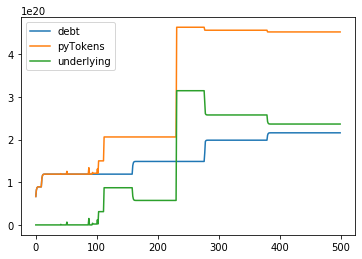

In [881]:
pandas.Series(debtOutstanding, name="debt").plot(legend=True)
pandas.Series(tSupply, name="pyTokens").plot(legend=True)
pandas.Series(ulying, name="underlying").plot(legend=True)

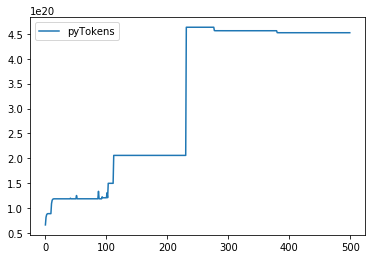

In [882]:
pandas.Series(tSupply, name="pyTokens").plot(legend=True)

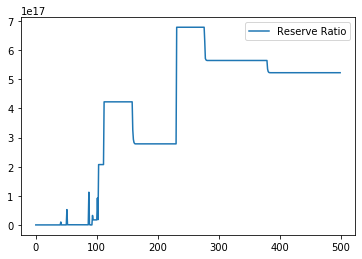

In [883]:
pandas.Series(qxA, name="Reserve Ratio").plot(legend=True)

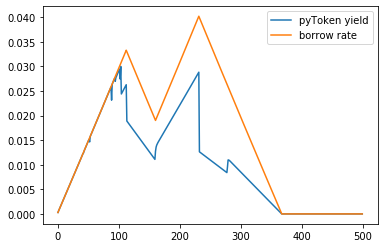

In [884]:
pandas.Series(pyratesA, name="pyToken yield").plot(legend=True)
pandas.Series(debtratesA,name="borrow rate").plot(legend=True)

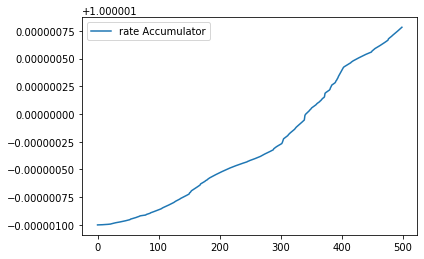

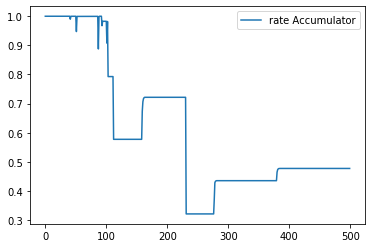

In [885]:
pandas.Series(debtSupplyRatio,name="Debt Supply Ratio").plot(legend=True)

In [870]:
pyA._counts

{'addCollateral': 12,
 'collateralizationRatio': 12,
 'debtInUnderlying': 2898,
 'getCollateralBalance': 1774,
 'completeBorrow': 57,
 'updateRates': 500,
 'accrueInterest': 500,
 'lastBlockInterest': 500,
 'balanceOf': 4126,
 'rateAccumulator': 500,
 'underlyingHeld': 120,
 'totalSupply': 500,
 'getTotalDebt': 1000,
 'getReserveRatio': 500,
 'debtRate': 500,
 'mint': 47,
 'redeem': 75,
 'repay': 29}

In [811]:
utoken.contract.functions.totalSupply().call()/10**18

1172290.0

In [812]:
ctoken.contract.functions.totalSupply().call()/10**18

2600.0

In [804]:
pyA.debtInUnderlying(users[1].address)/10**18

29.73625778526433

In [805]:
pyA._counts

{'addCollateral': 26,
 'collateralizationRatio': 26,
 'debtInUnderlying': 9179,
 'getCollateralBalance': 1567,
 'completeBorrow': 54,
 'updateRates': 736,
 'accrueInterest': 736,
 'lastBlockInterest': 736,
 'balanceOf': 10635,
 'rateAccumulator': 11370,
 'underlyingHeld': 11370,
 'totalSupply': 735,
 'getTotalDebt': 1470,
 'getReserveRatio': 735,
 'debtRate': 735,
 'mint': 5220,
 'redeem': 6272}

In [413]:
user2.address

'0x704cF59B16Fd50Efd575342B46Ce9C5e07076A4a'

In [414]:
user2.borrow()

Borrowed 3.2000 tokens at 0.0229


In [ ]:
    def borrow(self):
        price = unNumber(self.interface.oracle.endTWAP())
        #if we've already mostly borrowed what we desire, let's stop
        if unNumber(self.interface.pyA.debtInUnderlying("ETH", self.address)) > Decimal('.99') * self.desiredBorrow:
            return
        #initiate borrow
        borrowRatio = Decimal('0.5')
        amount = self.maximumBorrow() - unNumber(self.interface.pyA.debtInUnderlying("ETH", self.address))
        borrow = (Decimal(amount) * borrowRatio) / Decimal(self.collateralizationRatio )
        if borrow > Decimal('0.1'):
            self.interface.pyA.borrow("ETH", self.address, fNumber(borrow))
            print("Borrowed {} tokens at {}".format(round(borrow, 4), round(self.lowerRate, 4) ))

In [388]:
price = unNumber(pyoracle.endTWAP())
price

Decimal('2')

In [390]:
unNumber(pyA.debtInUnderlying( user2.address))

Decimal('0')

In [282]:
borrowRatio = Decimal('0.5')

In [391]:
user2.maximumBorrow()

Decimal('1.08E-17')

In [393]:
pyA.debtInUnderlying(user2.address)

0

In [485]:
pyA.yearlyDebtRate()

Decimal('0.120745737041099193669730801')

In [ ]:
pyA.pytoken.functions.getCollateralBalance(address).call()

In [486]:
pyA.yearlyRate()

Decimal('3.41987375476640881E-10')

In [ ]:
    def maximumBorrow(self): 
        return unNumber(self.interface.pyA.getCollateralBalance(self.address))* unNumber(self.interface.oracle.endTWAP())/  \
                    (self.collateralizationRatio * 10**18)
    

In [252]:
unNumber(10000000000000)

Decimal('0.00001')

In [396]:
unNumber(pyA.getCollateralBalance(user2.address))

Decimal('8.1')

In [398]:
unNumber(pyoracle.endTWAP())

Decimal('2')

In [399]:
user2.collateralizationRatio

Decimal('1.5')

In [ ]:
    debtRate '1.0000000000316216e+27'
    Time
    3
    ADIMs '1.0000000000948648e+27'
    DebtAccumulator  '1.0000000006355936e+27'
    DebtAccumulator  '1.0000000007304584e+27'
    All Debt  '28725686234749264000'
    New Debt  '2725054080'
    Fee Income '2725054'
    Total pyTokens '2.8725686213766347e+28'
    Total Supply '28725686213766350000'
    Rate Accumulator '1e+27'
    Last Block Interest '1e+27'

In [530]:
newDebt = 1624114215
totalPyTokens = 2.8725686213766347 * 10**28
totalSupply = 28725686213766350000

In [554]:
newDebt + ((28725686213766350000) * 10**27 / 10**18)

2.872568621376635e+28

In [556]:
2725054080 / 10**27

2.72505408e-18

In [555]:
((28725686213766350000) * 10**27 / 10**18)

2.872568621376635e+28

In [544]:
1.0000000007304584*10**27 - 1.0000000006355936*10**27

9.48647637328855e+16

In [546]:
(1.0000000007304584*10**27 - 1.0000000006355936*10**27)*28725686234749264000/(28725686213766350000 * 10**9)

94864763.80218025

In [547]:
2725054080/28725686234749264000

9.486471646771386e-11

In [531]:
(newDebt + totalPyTokens)/totalPyTokens

1.0

In [532]:
debtRate = 1.0000000000316216 * 10**27
time = 3
debtAccumulator = 1.0000000007304584 * 10**27

In [533]:
debtRate - 10**27

3.1621542097977344e+16

In [534]:
adim = 10**27 + (debtRate - 10**27) * 3
adim

1.0000000000948646e+27

In [535]:
(adim * debtAccumulator)/10**27

1.000000000825323e+27

In [536]:
((newDebt + totalPyTokens) * 10**27)/totalPyTokens

1e+27

In [537]:
(newDebt * 10**27)/totalPyTokens

56538743.858507656

In [538]:
(newDebt + totalPyTokens) / totalPyTokens

1.0

In [542]:
((newDebt + totalPyTokens) * 10**27)/(totalSupply * 10**9)

9.999999999999999e+26

In [543]:
((totalPyTokens) * 10**27)/(totalSupply * 10**9)

9.999999999999999e+26

In [745]:
Decimal(2451842007066141700) / Decimal(8.920177310601449 * 10**28)

Decimal('2.748647164392323819814213514E-11')

In [ ]:
1.0000000060286995e+27
1.0000000041346233e+27